# Pierce - Multiomics
Author: Leo Joseph (l1joseph@ucsd.edu)

In [39]:
import os
import pandas as pd
import numpy as np
import biom
from qiime2 import Metadata, Artifact
from skbio.stats.composition import clr_inv as softmax
from skbio.stats.composition import clr
from qiime2.plugins.gemelli.actions import (joint_rpca, filter_ordination, feature_correlation_table)
from qiime2.plugins.longitudinal.actions import volatility

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
%matplotlib inline

## Load Pierce Samples

In [40]:
table_metag = biom.load_table('out/195330_none.zebra.biom')
table_metag_df = table_metag.to_dataframe().T
table_metab_df = pd.read_csv("mzmine/feature_table.csv", sep=',', dtype="str", index_col=0)
metadata = Metadata.load('qiita/15350_20240110-175840_noblanks.txt')
metadata = metadata.to_dataframe()
new_metadata = pd.read_csv('mzmine/metadata_metabolomics.csv', sep = ',')

### Preprocess metaB

In [45]:
old_to_new_sample_id = {
    'C7V9J': 'C7V5J',
    'C3E3G': 'C3R3G',
    'C252P': 'C2S2P',
    'A8C0X': 'A8C6X',
    'B3K9Y': 'B3X9Y',
    'B5C9P': 'B5L9P',
    'CW58B': 'C2S8B',
    'A9KJA': 'A9K5A',
    'B258R': 'B2S8R'
}

old_sample_id_to_new_sample_name = {
    'C7V9J': '15350.C7V5J.1',
    'C3E3G': '15350.C3R3G.1',
    'C252P': '15350.C2S2P.1',
    'A8C0X': '15350.A8C6X.2',
    'B3K9Y': '15350.B3X9Y.1',
    'B5C9P': '15350.B5L9P.1',
    'CW58B': '15350.C2S8B.1',
    'A9KJA': '15350.A9K5A.1',
    'B258R': '15350.B2S8R.1'
}

metadata_updated = new_metadata.copy()

for old_id, new_id in old_to_new_sample_id.items():
    mask = metadata_updated['sample_id'] == old_id
    
    metadata_updated.loc[mask, 'sample_id'] = new_id
    
    metadata_updated.loc[mask, 'sample_name'] = old_sample_id_to_new_sample_name[old_id]

verification = [old_id for old_id in old_to_new_sample_id.keys() 
                if old_id in metadata_updated['sample_id'].values]

new_metadata = metadata_updated

Number of old sample_ids still present: 0
All sample_ids were successfully updated!

Sample of updated metadata:
  sample_id    sample_name
0     A5U7C  15350.A5U7C.2
1     A6N5R  15350.A6N5R.1
2     A6T5B  15350.A6T5B.1
3     A7B7Z  15350.A7B7Z.1
4     A7L6P  15350.A7L6P.1
5     A7U2D  15350.A7U2D.1
6     A7U7E  15350.A7U7E.1
7     A7Z3W  15350.A7Z3W.1
8     A8B6R  15350.A8B6R.2
9     A8K2F  15350.A8K2F.1


In [46]:
new_metadata['SampleID'] = new_metadata['SampleID'].astype(str)
table_metab_df.index = table_metab_df.index.astype(str)

new_metadata['sample_name'] = new_metadata['sample_name'].astype(str)
table_metag_df.index = table_metag_df.index.astype(str)

samples_in_metab = set(table_metab_df.index)
metadata_metab_match = new_metadata[new_metadata['SampleID'].isin(samples_in_metab)]

samples_in_metag = set(table_metag_df.index)
metadata_metag_match = new_metadata[new_metadata['sample_name'].isin(samples_in_metag)]

final_metadata = metadata_metab_match[metadata_metab_match['sample_name'].isin(samples_in_metag)]

final_sample_ids = set(final_metadata['SampleID'])
final_sample_names = set(final_metadata['sample_name'])

new_metadata_subset = new_metadata[new_metadata['SampleID'].isin(final_sample_ids)]
table_metab_df_subset = table_metab_df[table_metab_df.index.isin(final_sample_ids)]
table_metag_df_subset = table_metag_df.loc[list(final_sample_names)]

In [51]:

sample_id_to_name_map = dict(zip(new_metadata_subset['SampleID'], new_metadata_subset['sample_name']))

qiita_metadata_df_subset = metadata[metadata.index.isin(new_metadata_subset['sample_name'])]


missing_samples = set(new_metadata_subset['sample_name']) - set(qiita_metadata_df_subset.index)
table_metab_df_subset_reindexed = table_metab_df_subset.copy()

sample_names = [sample_id_to_name_map.get(sid) for sid in table_metab_df_subset.index]

table_metab_df_subset_reindexed.index = sample_names
table_metab_df_subset = table_metab_df_subset_reindexed

index_matches = set(table_metab_df_subset_reindexed.index) == set(new_metadata_subset['sample_name'])

Original metadata: 83 samples
Subsetted qiita_metadata_df_subset: 81 samples
Number of samples in new_metadata_subset: 81 samples
Samples in new_metadata_subset missing from qiita_metadata_df_subset: 0

Table index verification:
First 5 SampleIDs: ['15350.C3Z6R.1', '15350.B4B4Z.1', '15350.B2S8R.1', '15350.B3K7K.1', '15350.C3V4G.1']
First 5 new indices (sample_names): ['15350.C3Z6R.1', '15350.B4B4Z.1', '15350.B2S8R.1', '15350.B3K7K.1', '15350.C3V4G.1']
All indices match sample_names in new_metadata_subset: True


In [52]:
new_sample_names = list(old_sample_id_to_new_sample_name.values())

present_sample_names = [name for name in new_sample_names if name in metadata.index]
missing_sample_names = [name for name in new_sample_names if name not in metadata.index]

if present_sample_names:
    for name in present_sample_names:
        print(f"- {name}")

if missing_sample_names:
    for name in missing_sample_names:
        print(f"- {name}")

Sample names check results:
- Total sample names to check: 9
- Sample names present in metadata.index: 9
- Sample names missing from metadata.index: 0

Present sample names:
- 15350.C7V5J.1
- 15350.C3R3G.1
- 15350.C2S2P.1
- 15350.A8C6X.2
- 15350.B3X9Y.1
- 15350.B5L9P.1
- 15350.C2S8B.1
- 15350.A9K5A.1
- 15350.B2S8R.1


### Save artifacts and metadata

In [56]:
table_metag_biom = biom.Table(table_metag_df_subset.values.T, observation_ids=table_metag_df_subset.columns, sample_ids=table_metag_df_subset.index)
table_metab_biom = biom.Table(table_metab_df_subset.values.T, observation_ids=table_metab_df_subset.columns, sample_ids=table_metab_df_subset.index)


In [57]:

with biom.util.biom_open('out/multiomics/metag.biom', 'w') as f:
    table_metag_biom.to_hdf5(f, "example")
with biom.util.biom_open('out/multiomics/metab.biom', 'w') as f:
    table_metab_biom.to_hdf5(f, "example")
qiita_metadata_df_subset.to_csv('out/multiomics/metadata.tsv', sep='\t', index=True)
Metadata(qiita_metadata_df_subset).save('out/multiomics/metadata.qza')
metadata_q2 = Metadata(qiita_metadata_df_subset)

## Run Joint-RPCA

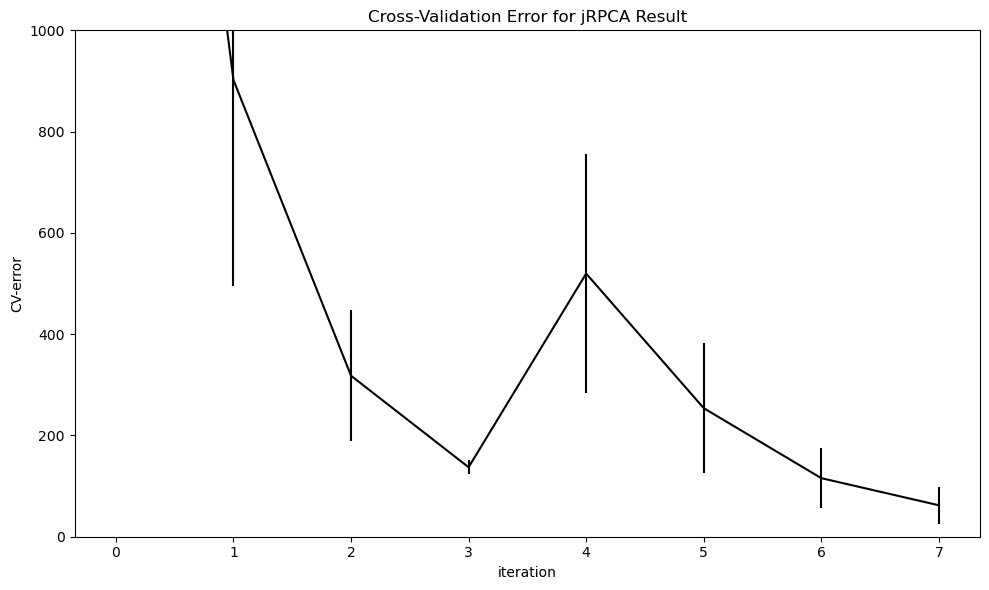

In [31]:
table_metag_qza = Artifact.import_data("FeatureTable[Frequency]", table_metag_biom)
table_metab_qza = Artifact.import_data("FeatureTable[Frequency]", table_metab_biom)

jrpca_result = joint_rpca([table_metag_qza, table_metab_qza], sample_metadata=metadata_q2, min_feature_frequency=0, max_iterations=8)

os.makedirs('out/multiomics/joint-rpca', exist_ok=True)
jrpca_result.biplot.save(f'out/multiomics/joint-rpca/joint_biplot-all.qza')
jrpca_result.distance_matrix.save(f'out/multiomics/joint-rpca/joint_distance_matrix-all.qza')
jrpca_result.cross_validation_error.save(f'out/multiomics/joint-rpca/cross_validation_error-all.qza')

# volatility
volatility_plot = volatility(jrpca_result.cross_validation_error.view(Metadata), 'iteration')
volatility_plot.visualization.save(f'out/multiomics/joint-rpca/volatility_plot-all.qzv')

fig, ax = plt.subplots(figsize=(10, 6))
df_plt = jrpca_result.cross_validation_error.view(Metadata).to_dataframe()
ax.errorbar(x=df_plt['iteration'], y=df_plt['mean_CV'], yerr=df_plt['std_CV'], c='black')

ax.set_ylabel('CV-error', color='black')
ax.set_xlabel('iteration', color='black')
ax.set_ylim(0, 1000)
ax.set_title('Cross-Validation Error for jRPCA Result')

plt.tight_layout()
plt.show()


In [32]:
correlation_table = feature_correlation_table(jrpca_result.biplot).correlation_table
correlation_table.save('out/multiomics/joint-rpca/correlation_table-all.qza')


'out/multiomics/joint-rpca/correlation_table-all.qza'

In [33]:

try:
    raw_df = correlation_table._view(pd.DataFrame)
    if 'SampleID' in raw_df.columns:
        raw_df = raw_df.rename(columns={'SampleID': 'Sample_ID'})
    correlation_table_df = raw_df
except:
    temp_file = 'temp_correlation_table.tsv'
    os.system(f'qiime tools export --input-path out/multiomics/joint-rpca/correlation_table-all.qza --output-path temp_export/')
    correlation_table_df = pd.read_csv('temp_export/Correlation.tsv', sep='\t')
    if 'SampleID' in correlation_table_df.columns:
        correlation_table_df = correlation_table_df.rename(columns={'SampleID': 'Sample_ID'})

In [36]:
correlation_table_df.to_csv('out/multiomics/joint-rpca/correlation_table-all.tsv', sep='\t', index=True)



In [59]:
correlation_table_df = pd.read_csv('out/multiomics/joint-rpca/correlation_table-all.tsv', sep='\t', index_col=0)


/var/folders/tx/vgccmrkj1fz1zv99j496_3k80000gn/T/ipykernel_17001/1949998055.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  correlation_table_df = pd.read_csv('out/multiomics/joint-rpca/correlation_table-all.tsv', sep='\t', index_col=0)


,G000006865,G000006925,G000007525,G000008345,G000008865,G000009925,G000010425,G000011065,G000012005,G000012825,...,32020,10221,28732,36243,10281,23436,35388,36868,5925,10297
featureid,,,,,,,,,,,,,,,,,,,,,
G000006865,1.000000,-0.118470,-0.999063,0.891131,-0.151740,-0.881929,-0.764248,-0.879057,-0.067942,-0.893152,...,-0.103202,-0.116198,0.202189,0.240365,-0.008474,0.344763,0.551390,0.238783,-0.354656,-0.247787
G000006925,-0.118470,1.000000,0.142309,0.190687,0.999422,-0.097711,0.591776,-0.258986,0.976581,-0.278296,...,-0.615393,-0.105960,0.551531,-0.025550,0.274492,0.350524,-0.762553,0.702703,-0.768948,0.957868
G000007525,-0.999063,0.142309,1.000000,-0.895388,0.175626,0.891474,0.761278,0.880406,0.083867,0.891232,...,0.060252,0.148621,-0.216399,-0.274962,0.049665,-0.365558,-0.551616,-0.243567,0.350987,0.279216
G000008345,0.891131,0.190687,-0.895388,1.000000,0.157889,-0.992003,-0.393218,-0.997010,0.302165,-0.989765,...,-0.018002,-0.476553,0.622974,0.546909,-0.253997,0.716065,0.127864,0.648920,-0.715329,-0.028429
G000008865,-0.151740,0.999422,0.175626,0.157889,1.000000,-0.065214,0.612800,-0.226472,0.973303,-0.245618,...,-0.613109,-0.096377,0.538027,-0.038649,0.278560,0.332793,-0.775340,0.688088,-0.751045,0.963184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23436,0.344763,0.350524,-0.365558,0.716065,0.332793,-0.746498,0.277430,-0.707735,0.539679,-0.655857,...,0.369585,-0.927488,0.970693,0.910983,-0.713313,1.000000,-0.470426,0.911984,-0.831964,0.067285
35388,0.551390,-0.762553,-0.551616,0.127864,-0.775340,-0.151798,-0.956661,-0.090159,-0.816830,-0.117498,...,0.040957,0.464701,-0.651090,-0.306792,0.234956,-0.470426,1.000000,-0.670527,0.582970,-0.679097
36868,0.238783,0.702703,-0.243567,0.648920,0.688088,-0.629717,0.443310,-0.672785,0.834643,-0.643341,...,-0.003603,-0.740837,0.974871,0.674263,-0.408010,0.911984,-0.670527,1.000000,-0.974187,0.468782


## Run MMVec

In [54]:


!mmvec paired-omics \
    --microbe-file ../out/multiomics/metag.biom \
    --metabolite-file ../out/multiomics/metab.biom \
    --summary-dir ../out/multiomics/mmvec_summary

In [34]:
ranks = pd.read_table("out/multiomics/mmvec_summary/latent_dim_3_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95_ranks.txt", index_col=0)
probs = ranks.apply(softmax)